In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
from Data import get_setup
import os
from datetime import datetime
import timeit

import torch.nn.functional as F
import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm import trange
from Data import get_setup
from Inference_new import *
from Models.VI import *
from Tools import uniform_rect_sampler
import argparse


In [3]:
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [4]:
from Metrics import rmse, lpp, batch_entropy_nne, lpp_gaussian


def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

In [5]:
## small ##
# predictive model architecture
layerwidth = 50
nblayers = 1
activation = nn.ReLU()



In [6]:
MODELS=torch.load("Results/Paper/Exp2/Exp2_small2021-01-28-00:59_models.pt",map_location=device)
len(MODELS['yacht'])

10

In [7]:
datasets = ['boston', 'concrete', 'energy','wine','yacht']
# for key in MODELS.keys():
#     datasets.append(key)

methods=[ 'MC dropout','Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']
# for key in MODELS['energy'][0][1].keys():
#     methods.append(key)
    
datasets, methods

(['boston', 'concrete', 'energy', 'wine', 'yacht'],
 ['MC dropout', 'Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI'])

In [8]:
from Metrics import rmse, lpp, lpp_gaussian
def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

In [9]:
results=[]

for dataset in datasets:   

    for split in MODELS[dataset]:
        split_results={}
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']

        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test)
        metrics = get_metrics(y_pred, torch.tensor(0.), y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model.predict(x_test, 1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
            
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        #Results.append({dataset:split_results})

In [13]:
torch.save(results,'Results/Paper/Exp2/Exp2_small2021-01-28-00:59_results.pt')

# RMSE

In [48]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis_r')
#df_.style.highlight_min(axis=1)


,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,
boston,3.440620,3.393448,3.810121,4.265195,3.767234,3.731682
concrete,4.705565,4.126360,5.107623,5.644813,4.718403,4.748910
energy,0.565395,0.410518,0.462897,0.572665,0.436018,0.457268
wine,0.629961,0.640798,0.650620,0.674147,0.736191,0.695716
yacht,0.737811,0.680147,1.153483,1.709307,0.599634,0.909209


In [15]:
for i in df_.columns:
    df_[i] = df_[i].round(3).astype(str)+ "±" + (df_sem_[i].round(3)).astype(str)+""

In [16]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &   MC dropout &     Ensemble &         MFVI &    FuNN-MFVI &      NN-HyVI &    FuNN-HyVI \\
dataset  &              &              &              &              &              &              \\
\midrule
boston   &  3.441±0.343 &  3.393±0.339 &   3.81±0.248 &  4.265±0.476 &  3.767±0.479 &  3.732±0.229 \\
concrete &  4.706±0.177 &  4.126±0.227 &  5.108±0.151 &  5.645±0.235 &   4.718±0.16 &  4.749±0.266 \\
energy   &  0.565±0.022 &  0.411±0.021 &  0.463±0.022 &  0.573±0.034 &  0.436±0.038 &   0.457±0.04 \\
wine     &   0.63±0.014 &  0.641±0.017 &  0.651±0.014 &  0.674±0.012 &  0.736±0.015 &  0.696±0.019 \\
yacht    &  0.738±0.076 &    0.68±0.07 &  1.153±0.074 &  1.709±0.168 &    0.6±0.066 &  0.909±0.092 \\
\bottomrule
\end{tabular}



# LPP

In [49]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis')
#df_.style.highlight_max(axis=1)


,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,
boston,-6.749243,-4.242977,-2.836688,-7.510282,-4.432235,-13.370382
concrete,-5.348866,-6.191169,-3.084056,-3.613256,-3.260132,-3.601495
energy,-1.004216,-1.785005,-0.665931,-1.308917,-0.564559,-0.876462
wine,-11.634835,-2.352902,-0.991822,-1.198351,-1.359980,-1.452601
yacht,-0.597512,-0.797440,-1.655481,-4.467177,-0.892643,-4.420307


In [18]:
for i in df_.columns:
    df_[i] = df_[i].round(3).astype(str)+ "±" + (df_sem_[i].round(3)).astype(str)+""

In [19]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &     MC dropout &      Ensemble &          MFVI &     FuNN-MFVI &       NN-HyVI &     FuNN-HyVI \\
dataset  &                &               &               &               &               &               \\
\midrule
boston   &   -6.749±0.691 &  -4.243±0.304 &  -2.837±0.098 &   -7.51±2.226 &  -4.432±0.918 &  -13.37±1.284 \\
concrete &   -5.349±0.313 &  -6.191±1.566 &  -3.084±0.041 &  -3.613±0.143 &   -3.26±0.106 &  -3.601±0.219 \\
energy   &   -1.004±0.047 &  -1.785±0.281 &  -0.666±0.049 &  -1.309±0.128 &   -0.565±0.08 &  -0.876±0.217 \\
wine     &  -11.635±1.247 &  -2.353±0.193 &  -0.992±0.024 &  -1.198±0.041 &   -1.36±0.051 &  -1.453±0.066 \\
yacht    &   -0.598±0.035 &  -0.797±0.394 &  -1.655±0.125 &  -4.467±0.587 &  -0.893±0.217 &   -4.42±1.313 \\
\bottomrule
\end{tabular}



# displaying logs

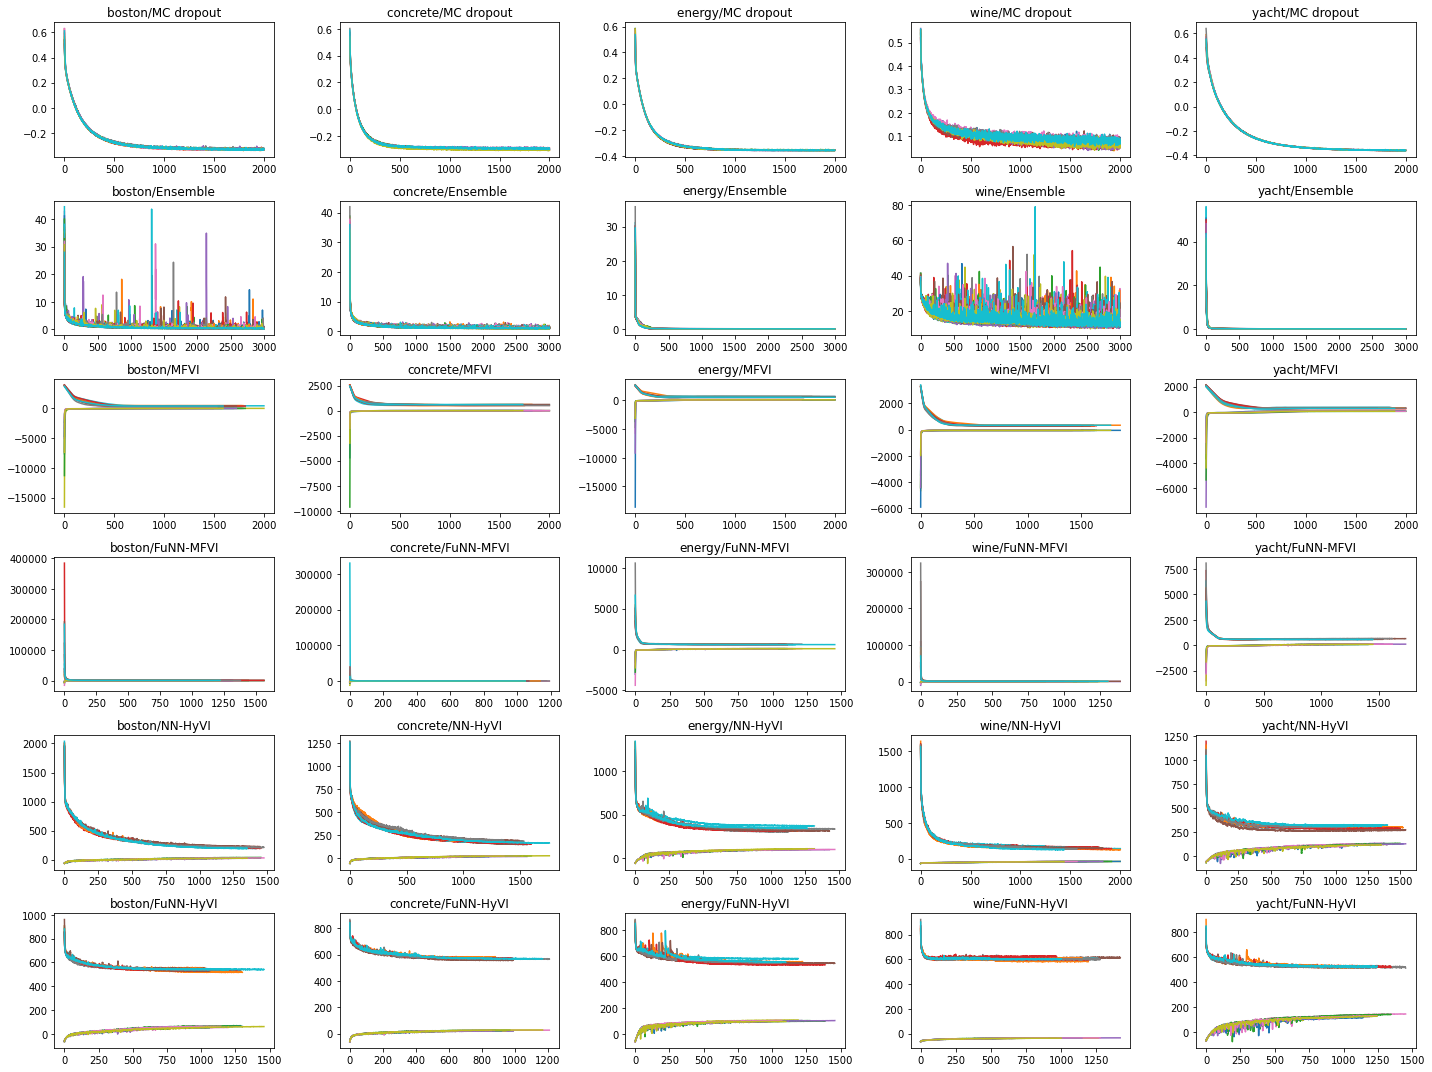

In [20]:
from pylab import *
fig, ax=plt.subplots(len(methods), len(datasets), figsize=(20,15))
ax=ax.flatten()
i=0
for method in methods:
    for dataset in datasets:
        for split in MODELS[dataset]: 
            logs=split[1][method][1]
            for key in logs.keys():
                if key=='KL' or key=='loss' or key=='LL' or isinstance(key, int): 
                    ax[i].plot(range(len(logs[key])), logs[key])
                #ax[i].legend()
                ax[i].set_title(dataset+'/'+method)
        i+=1

fig.tight_layout()

# OOD detection

In [68]:
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

#Hs={dataset:{method: [] for method in methods} for dataset in datasets}
#MODELS.to(device)
def Entropy(model, X):
    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]

def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)


for dataset in ['concrete', 'energy','wine','yacht']:
    print(dataset)
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=10000)
        x_OOD=OOD_sampler()
        
        X = [x_train, x_test, x_OOD]

        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Y = [model(x) for x in X]
        H = [univariate_gaussian_entropy(sigma=y.std(0).squeeze()) for y in Y]  
        Hs[dataset][method].append(H)

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        Y=[model.predict(x, 1000) for x in X]
        H = [univariate_gaussian_entropy(sigma=y.std(0).squeeze()) for y in Y]  
        Hs[dataset][method].append(H)
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][method].append(Entropy(model, X))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][method].append(Entropy(model, X))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][method].append(Entropy(model, X))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][method].append(Entropy(model, X))
        
        #torch.save(Hs,'Results/Paper/Exp2/Exp2_small2021-01-28-00:59_epist_entropy.pt')

concrete
0


RuntimeError: CUDA out of memory. Tried to allocate 1.86 GiB (GPU 0; 10.76 GiB total capacity; 468.47 MiB already allocated; 1.06 GiB free; 2.04 GiB reserved in total by PyTorch)

In [32]:
#torch.save(Hs,'Results/Paper/Exp2/Exp2_small2021-01-28-00:59_epist_entropy.pt')
Hs=torch.load('Results/Paper/Exp2/Exp2_small2021-01-28-00:59_epist_entropy.pt')

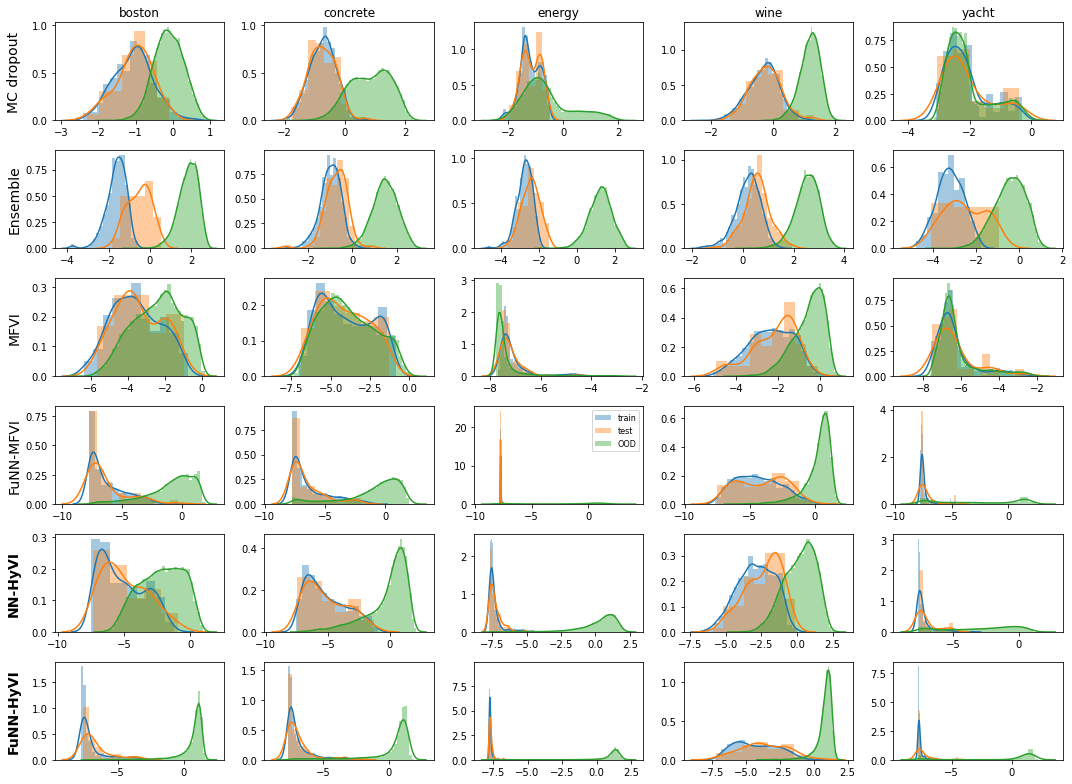

In [37]:
from pylab import *
import seaborn as sns

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)

n_datasets=len(datasets)
n_methods=len(methods)
fig,ax=plt.subplots(n_methods,n_datasets,figsize=(15,11),squeeze=False)


method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

label=['train', 'test', 'OOD']
split=1

d=0
for dataset in datasets:
    m=0
    ax[m,d].set_title(dataset)
    for method in methods:
        H=Hs[dataset][method][split]
        for i in range(len(H)):
            sns.distplot(H[i].cpu(), label=label[i], ax=ax[m,d], kde=True)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            if d ==0:
                if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                    ax[m,d].set_ylabel(method, {'fontweight':'bold'})
                else:
                    ax[m,d].set_ylabel(method)
        m+=1

    d+=1
ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
fig.align_ylabels(ax[:, 0])
plt.savefig("Results/Paper/Exp2/UCIsmall_PredictiveEntropy_Exp2-{}.pdf".format(split), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score
from pylab import *
import numpy as np
cmap=plt.get_cmap('Set1')

roc_data={dataset:[] for dataset in datasets}
AUC={}
for dataset in datasets:     
    for method in methods:
        AUCs=[]
        for h in Hs[dataset][method]:
            H_in=torch.cat([h[0],h[1]])
            H_ood, _=h[2].sort()
            y_true=torch.cat([torch.ones_like(torch.cat([h[0],h[1]])),torch.zeros_like(h[2])])
            y_score=-torch.cat([h[0],h[1],h[2]])
            AUCs.append(roc_auc_score(y_true.cpu(), y_score.cpu()))

            fpr=torch.arange(len(H_ood)).true_divide(len(H_ood))
            tpr=(H_in.unsqueeze(-1) < H_ood).sum(0).true_divide(len(H_in))
            roc_data[dataset]+=[{'fpr-ood': 0., 'tpr-id':0., 'method':method }]
            roc_data[dataset]+=[{'fpr-ood': fpr[i].item(), 'tpr-id':tpr[i].item(), 'method':method } for i in range(len(fpr))]
        
        AUC.update({(dataset,method):np.mean(AUCs)})
        print(dataset+"/"+method+": {}".format(np.mean(AUCs)))

boston/MC dropout: 0.9379942786561264
boston/Ensemble: 0.9994023715415018
boston/MFVI: 0.6980857707509881
boston/FuNN-MFVI: 0.9706882509881425
boston/NN-HyVI: 0.9238844466403162
boston/FuNN-HyVI: 0.9985391501976286
concrete/MC dropout: 0.9519446601941747
concrete/Ensemble: 0.9991271844660196
concrete/MFVI: 0.35738321359223296
concrete/FuNN-MFVI: 0.9483974951456311
concrete/NN-HyVI: 0.9563006504854368
concrete/FuNN-HyVI: 0.9908593592233009
energy/MC dropout: 0.7731062955729167
energy/Ensemble: 0.9999802213541666
energy/MFVI: 0.3884798567708333
energy/FuNN-MFVI: 0.96359158203125
energy/NN-HyVI: 0.9993745312500002
energy/FuNN-HyVI: 0.9994706705729166
wine/MC dropout: 0.9925353001876174
wine/Ensemble: 0.9985011131957474
wine/MFVI: 0.8867200156347718
wine/FuNN-MFVI: 0.9849875453408382
wine/NN-HyVI: 0.9374522232645403
wine/FuNN-HyVI: 0.9978992120075046
yacht/MC dropout: 0.5258616396103896
yacht/Ensemble: 0.9946682305194805
yacht/MFVI: 0.5433986688311688
yacht/FuNN-MFVI: 0.9217736850649351
ya

In [65]:
torch.save(roc_data,'Results/Paper/Exp2/Exp2_small2021-01-28-00:59_roc_data.pt')
torch.save(AUC,'Results/Paper/Exp2/Exp2_small2021-01-28-00:59_AUC.pt')


In [66]:
for dataset in datasets:  
    for entry in roc_data[dataset]:
            entry['method']=entry['method']+" AUC={}".format(AUC[(dataset,entry['method'])].round(3))
data={dataset: pd.DataFrame(roc_data[dataset]) for dataset, roc in roc_data.items()}


In [ ]:
data['concrete']

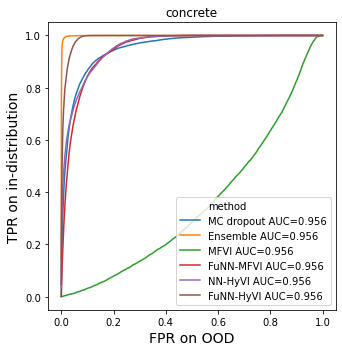

In [61]:
import seaborn as sns
l=len(datasets)
fig, ax= plt.subplots(1,figsize=(5,5))

dataset='concrete'

sns.lineplot(data=data[dataset], x="fpr-ood", y="tpr-id", hue="method", ax=ax, ci=None)
ax.set_title(dataset)
ax.set_xlabel('FPR on OOD')
ax.set_ylabel('TPR on in-distribution')
ax.set_aspect('equal')


fig.tight_layout()

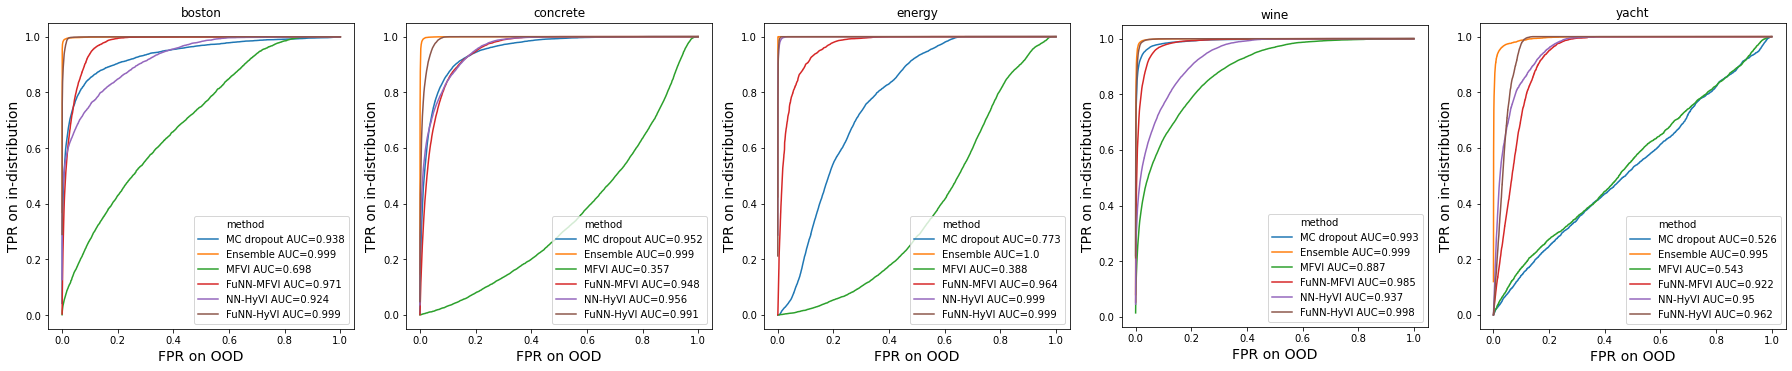

In [69]:
import seaborn as sns
l=len(datasets)
fig, ax= plt.subplots(1,l,figsize=(5*l,5))
d=0

for dataset in datasets:  
    
    sns.lineplot(data=data[dataset], x="fpr-ood", y="tpr-id", hue="method", ax=ax[d],  ci=None)
        #custom_text.append(method+' (AUC:{})'.format(np.mean(AUCs).round(3)))
    #lgd = ax[d].legend(custom_lines, custom_text, loc='best')
    ax[d].set_title(dataset)
    ax[d].set_xlabel('FPR on OOD')
    ax[d].set_ylabel('TPR on in-distribution')
    ax[d].set_aspect('equal')
    d+=1


fig.tight_layout()

In [70]:
plt.savefig("Results/Paper/Exp2/UCIsmall_ROC_curves_Exp2.pdf", dpi=600)


<Figure size 432x288 with 0 Axes>